Notes
- the input dims are (500,500,3)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
# Constants
DATASET_BASE_DIR = "./archive/pizza_not_pizza"
folder_name_label = {"not_pizza": 0, "pizza": 1}
BATCH_SIZE = 32

In [3]:
class TrainingData:
    def __init__(self, base_dir, folder_label_map):
        """
        Initializes the TrainingData object.

        Args:
            base_dir (str): Path to the dataset base directory.
            folder_label_map (dict): Mapping of folder names to labels.
        """
        self.base_dir = base_dir
        self.folder_label_map = folder_label_map
        self.data = []  # To store (image, label) pairs

    def load_data(self):
        """
        Loads images and labels from the dataset directory.
        """
        for folder_name, label in self.folder_label_map.items():
            folder_path = os.path.join(self.base_dir, folder_name)
            if not os.path.exists(folder_path):
                print(f"Warning: Folder {folder_path} does not exist.")
                continue

            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if file_path.endswith((".png", ".jpg", ".jpeg")):  # Valid image formats
                    try:
                        image = Image.open(file_path)  # Read the image
                        # Consistent dimensions for the image
                        image = image.resize((256, 256))
                        self.data.append((image, label))  # Append (image, label) pair
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

        print(f"Loaded {len(self.data)} images.")

    def get_data(self):
        """
        Returns the loaded data as separate arrays for images and labels.

        Returns:
            tuple: (images, labels) where images is a NumPy array of all images and labels is a NumPy array of labels.
        """

        print(len(self.data))
        images, labels = zip(*self.data)  # Unzipping into separate lists
        return np.array(images), np.array(labels)


# Usage
training_data = TrainingData(DATASET_BASE_DIR, folder_name_label)
training_data.load_data()

# Retrieve images and labels
images, labels = training_data.get_data()
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Loaded 1966 images.
1966
Images shape: (1966, 256, 256, 3)
Labels shape: (1966,)


In [4]:
# Creating the split
X_train, X_test,y_train, y_test = train_test_split(images, labels, random_state=104, test_size=0.25, shuffle=True)

(256, 256, 3)
0


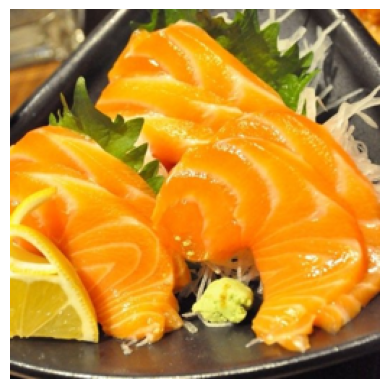

In [5]:
# Render a sample
idx = 421
print(X_train[idx].shape)
plt.imshow(X_train[idx])
plt.axis("off")
print(y_train[idx])
plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self, learning_rate=0.001):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second conv block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third conv block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of flattened features
        # After 3 max pooling layers with stride 2: 256 -> 128 -> 64 -> 32
        self.flatten_size = 128 * 32 * 32
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Sigmoid for binary classification
        )
        
        # Define loss function and optimizer
        self.criterion = nn.BCELoss()  # Binary Cross Entropy Loss
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        # Input shape: (batch_size, 3, 256, 256)
        x = self.conv_layers(x)
        # Flatten the output
        x = x.view(x.size(0), -1)
        # Pass through fully connected layers
        x = self.fc_layers(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch
        # Forward pass
        outputs = self(images)
        # Calculate loss
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def validation_step(self, batch):
        images, labels = batch
        with torch.no_grad():
            outputs = self(images)
            loss = self.criterion(outputs, labels.float().view(-1, 1))
            # Convert outputs to predictions (0 or 1)
            predictions = (outputs >= 0.5).float()
            accuracy = (predictions == labels.view(-1, 1)).float().mean()
        return loss.item(), accuracy.item()


In [11]:
# Training time #TODO figure out why the fuck is this bitch crashing. (x_x)

X_train_tensor = torch.FloatTensor(X_train) 
y_train_tensor = torch.FloatTensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model, move to device
device = torch.device("cpu")
model = CNN().to(device)

# Training parameters
num_epochs = 10
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    print(f"current epoch: {epoch}")

    # Progress bar for each epoch
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch_X, batch_y in progress_bar:
        # Move batch to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Ensure input dimensions are correct (B, C, H, W)
        if len(batch_X.shape) == 3:
            batch_X = batch_X.unsqueeze(1)  # Add channel dimension if missing

        # Forward pass
        loss = model.training_step((batch_X, batch_y))

        # Store batch loss
        epoch_losses.append(loss)

        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss:.4f}"})

    # Calculate average loss for the epoch
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)

    print(f"\nEpoch {epoch + 1}/{num_epochs}:")
    print(f"Average Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

: 